In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=400; dt=0.006
ntr=100

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def amp_spec(data):
    return abs(np.fft.rfft(data))

In [3]:
!cat setup_default

MODEL_SIZE              '101 101 1'
MODEL_SPACING           '20 20 1'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        'vp rho'
FILE_TOPO               'topo'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '40 400 500'
DR                      '0  20 0'
FR                      '40 0  0'
NR                      100

SCOMP                   p
RCOMP                   p #'p vz'

#IF_HICKS        F
#IF_BLOOM        F

NT           400
DT           0.006
FPEAK        7

SNAPSHOPT	    'p'

## for RWI ##
#FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'
FILE_DATA_PREFIX    'results_fwd/denv_Shot'
WEIGHTING           'none'

FPEAK        6.4
WAVELET_TYPE        'ricker'
T0                  0.35
UPDATE_WAVELET		'no'
RDT			0

PARAMETER           'vp:1500:2000'

SMOOTHING     'none'
#PRECO         'z^0'

#JOB             'forward modeling'
#JOB             'estimate wavelet'
JOB             'build tilD gradient'
#JOB             'update velocity gradient'

#DNO

## FWD

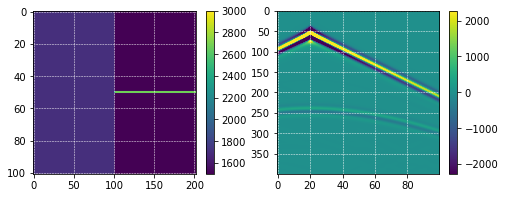

In [4]:
!makevel nz=$nz nx=$nx v000=1700 > vp
!makevel nz=$nz nx=$nx v000=1500 > rho0

!makevel nz=50 nx=$nx v000=1500 > r1
!makevel nz=1  nx=$nx v000=3000 > r2
!cat r1 r2 r1 > tmp && transp < tmp n1=$nz > rho
!rm r1 r2 tmp

## with reflections
!cat vp rho > model

!cp setup_default setup; echo "DIR_OUT 'results_fwd'" >> setup
!../../exe/FWD setup > out_fwd

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model',n=(2*nx,nz)))
plt.subplot(1,2,2); imshow(read_su('results_fwd/dsyn_Shot0001.su'),perc=98)

## Vp gradient under Vp-Ip

In [5]:
!makevel nz=$nz nx=$nx v000=1800 > vp
!makevel nz=$nz nx=$nx v000=1500 > rho0

!makevel nz=50 nx=$nx v000=1500 > r1
!makevel nz=1  nx=$nx v000=3000 > r2
!cat r1 r2 r1 > tmp && transp < tmp n1=$nz > rho
!rm r1 r2 tmp

!cat vp rho0 rho > model

!cp setup_default setup
!echo "DIR_OUT             'results_grad'" >> setup
!echo "MODEL_ATTRIBUTES    'vp rho0 rho'" >> setup
!echo "PARAMETER           'vp:1500:2000'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa d/r:1/5'" >> setup
!echo "JOB                 'update Vp gradient'" >> setup

!../../exe/RWI setup > out_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


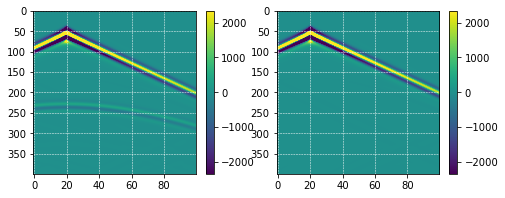

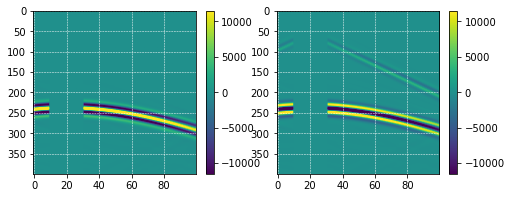

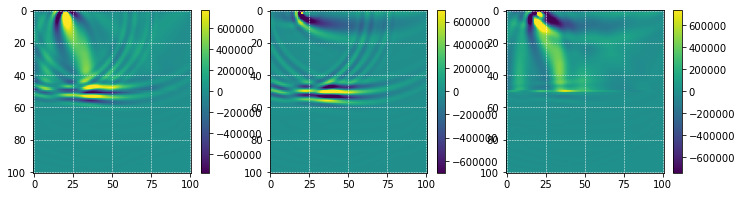

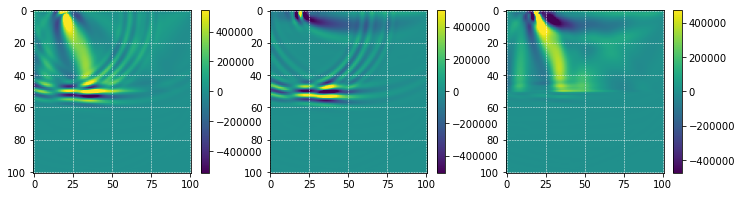

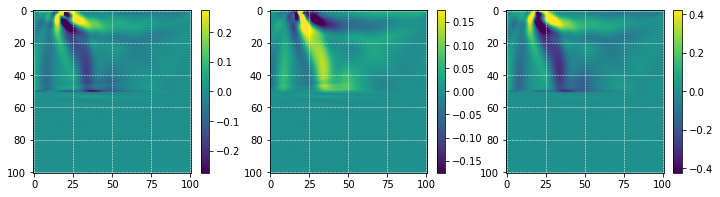

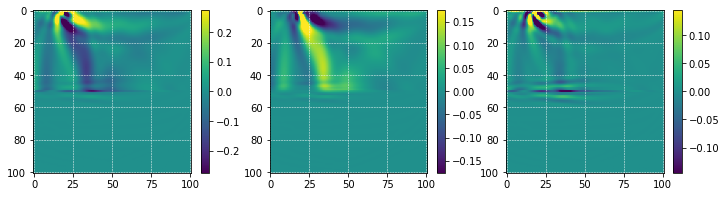

In [6]:
res='results_grad/'

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read_su(res+'Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su(res+'Ru0_Shot0001.su'),perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read_su(res+'dadj_refl_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su(res+'dadj_div-refl_Shot0001.su'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read(res+'a_star_u%rp_div_sv'); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp2=read(res+'a0_star_u0%rp_div_sv'); imshow(tmp2,perc=99)
plt.subplot(1,3,3);imshow(tmp1+tmp2,perc=99)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read(res+'a_star_u%rv_grad_sp'); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp2=read(res+'a0_star_u0%rv_grad_sp'); imshow(tmp2,perc=99)
plt.subplot(1,3,3);imshow(tmp1+tmp2,perc=99)

plt.figure(figsize=(12,3))
corr=read(res+'correlate_gradient',n=(2*nx,nz))
plt.subplot(1,3,1);imshow(corr[:,:nx]*1800,perc=99) #corr1=gkpa
plt.subplot(1,3,2);imshow(corr[:,nx:]/1800,perc=99) #corr2=grho
plt.subplot(1,3,3);imshow(corr[:,:nx]*1800-corr[:,nx:]/1800,perc=99) #gvp=gkpa*vp*rho-grho0*rho/vp

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);imshow(corr[:,:nx]*1800,perc=99) #corr1=gkpa
plt.subplot(1,3,2);imshow(corr[:,nx:]/1800,perc=99) #corr2=grho
plt.subplot(1,3,3);imshow(corr[:,:nx]*1800+corr[:,nx:]/1800,perc=99) #grho=gkpa*vp+grho0/vp

### GradientTest

In [7]:
!makevel nz=1 nx=$nx v000=100 > topo

!makevel nz=$nz nx=$nx v000=1800 > vp
!makevel nz=$nz nx=$nx v000=1500 > rho0

!makevel nz=50 nx=$nx v000=1500 > r1
!makevel nz=1  nx=$nx v000=3000 > r2
!cat r1 r2 r1 > tmp && transp < tmp n1=$nz > rho
!rm r1 r2 tmp

!cat vp rho0 rho > model

!make App=RWI

!cp setup_default setup
!echo "MODEL_ATTRIBUTES    'vp rho0 rho'" >> setup
!echo "PARAMETER           'vp:1500:2000'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa d/r:1/5'" >> setup
!echo "JOB                 'update Vp'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup
#!echo "ALPHAS '1 1e2 1e3 1e4' " >> setup

!../../exe/GradientTest  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_velocities-impedance.f90 m_querypoint.f90 m_weighter.f90 m_preconditio

In [8]:
!cp setup_default setup
!echo "MODEL_ATTRIBUTES    'vp rho0 rho'" >> setup
!echo "PARAMETER           'vp:1500:2000'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa d/r:1/5'" >> setup
!echo "JOB                 'update Vp'" >> setup
#!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup
!echo "ALPHAS '1 1e2 1e3 1e4' " >> setup

!../../exe/GradientTest  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   1.00000000       3.73351669       3.91827941     -0.184762716     -0.210611373       1.13990188     T
 1st cond   100.000000       1.82174027       3.91827941      -2.09653899E-02 -0.210611373       10.0456696     T
 1st cond   1000.00000       3.10533261       3.91827941      -8.12946819E-04 -0.210611373       259.071533     T
 1st cond   10000.0000       3.15604901       3.91827941      -7.62230411E-05 -0.210611373       2763.09326     T


## Ip gradient under Vp-Ip

In [9]:
!makevel nz=$nz nx=$nx v000=1800 > vp
!makevel nz=$nz nx=$nx v000=1500 > rho

!cat vp rho > model

!cp setup_default setup
!echo "DIR_OUT             'results_grad'" >> setup
!echo "MODEL_ATTRIBUTES    'vp rho'" >> setup
!echo "PARAMETER           'ip:2.25e6:6e6'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa'" >> setup
!echo "JOB                 'build Ip gradient'" >> setup

!../../exe/RWI setup > out_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG


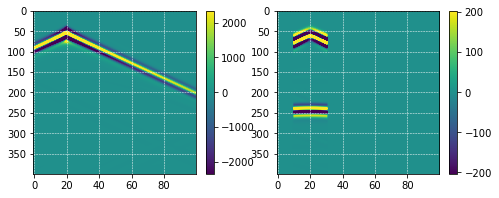

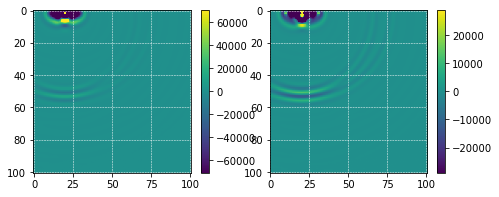

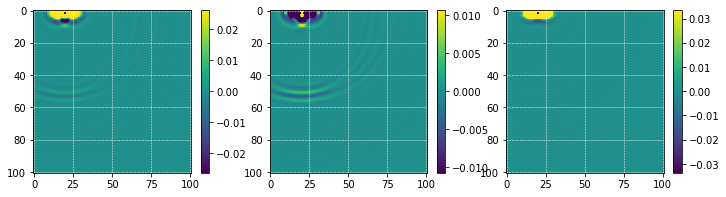

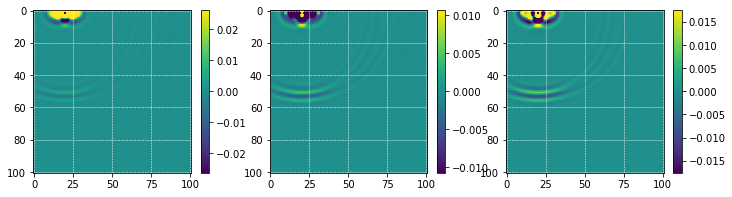

In [10]:
res='results_grad/'

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read_su(res+'Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su(res+'dadj_Shot0001.su'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read(res+'a_star_u%rp_div_sv'); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp1=read(res+'a_star_u%rv_grad_sp'); imshow(tmp1,perc=99)

plt.figure(figsize=(12,3))
corr=read(res+'correlate_gradient',n=(2*nx,nz))
plt.subplot(1,3,1);imshow(corr[:,:nx]*1800,perc=99) #corr1=gkpa
plt.subplot(1,3,2);imshow(corr[:,nx:]/1800,perc=99) #corr2=grho
plt.subplot(1,3,3);imshow(corr[:,:nx]*1800-corr[:,nx:]/1800,perc=99) #gvp=gkpa*vp*rho-grho0*rho/vp

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);imshow(corr[:,:nx]*1800,perc=99) #corr1=gkpa
plt.subplot(1,3,2);imshow(corr[:,nx:]/1800,perc=99) #corr2=grho
plt.subplot(1,3,3);imshow(corr[:,:nx]*1800+corr[:,nx:]/1800,perc=99) #grho=gkpa*vp+grho0/vp

### Ip gradient test

In [11]:
!makevel nz=1 nx=$nx v000=100 > topo

!makevel nz=$nz nx=$nx v000=1800 > vp
!makevel nz=$nz nx=$nx v000=1500 > rho

!cat vp rho > model

!make App=RWI

!cp setup_default setup
!echo "DIR_OUT             'results_grad'" >> setup
!echo "MODEL_ATTRIBUTES    'vp rho'" >> setup
!echo "PARAMETER           'ip:2.25e6:6e6'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa'" >> setup
!echo "JOB                 'build Ip'" >> setup
!echo "ALPHAS '1e-3 1e-2 1e-1 1' " >> setup
#!echo "ALPHAS '1 1e2 1e3 1e4' " >> setup

!../../exe/GradientTest  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_velocities-impedance.f90 m_querypoint.f90 m_weighter.f90 m_preconditio

In [12]:
!cp setup_default setup
!echo "DIR_OUT             'results_grad'" >> setup
!echo "MODEL_ATTRIBUTES    'vp rho'" >> setup
!echo "PARAMETER           'ip:2.25e6:6e6'" >> setup
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup
!echo "SEPARATING          'aoffset:200 polygon:sepa'" >> setup
!echo "JOB                 'build Ip'" >> setup
#!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup
!echo "ALPHAS '1 1e2 1e3 1e4' " >> setup

!../../exe/GradientTest  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   1.00000000       1.70227999E-04   1.70239669E-04  -1.16706360E-08  -1.20614789E-08   1.03348947     T
 1st cond   100.000000       1.69079634E-04   1.70239669E-04  -1.16003500E-08  -1.20614789E-08   1.03975129     T
 1st cond   1000.00000       1.59300573E-04   1.70239669E-04  -1.09390967E-08  -1.20614789E-08   1.10260284     T
 1st cond   10000.0000       1.21697514E-04   1.70239669E-04  -4.85421570E-09  -1.20614789E-08   2.48474312     T
